In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Import Model wrappers and metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Import Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, roc_auc_score, accuracy_score

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [5]:
import boto3
from io import BytesIO

from dotenv import load_dotenv

load_dotenv()  # Load environment variables from .env file
# initialize the S3 client
s3 = boto3.client('s3',
                  aws_access_key_id=os.getenv('aws_access_key_id'),
                  aws_secret_access_key=os.getenv('aws_secret_access_key'),
                  region_name='us-east-2')  # specify your region

# specify the bucket name and file key
bucket_name = 'dw-health-lifestyle-dataset'
file_key = 'health_lifestyle_dataset.csv'

try:
    # 2. Get the object from S3
    response = s3.get_object(Bucket=bucket_name, Key=file_key)
    
    # 3. Read the body of the response
    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

    if status == 200:
        print(f"Successful S3 connection. Loading {file_key}...")
        # 4. Load into Pandas using BytesIO (acts like a file in memory)
        df = pd.read_csv(BytesIO(response['Body'].read()))
        print(df.head())
    else:
        print(f"Unsuccessful: {status}")

except Exception as e:
    print(f"Error: {e}")

Successful S3 connection. Loading health_lifestyle_dataset.csv...
   id  age  gender   bmi  daily_steps  sleep_hours  water_intake_l  \
0   1   56    Male  20.5         4198          3.9             3.4   
1   2   69  Female  33.3        14359          9.0             4.7   
2   3   46    Male  31.6         1817          6.6             4.2   
3   4   32  Female  38.2        15772          3.6             2.0   
4   5   60  Female  33.6         6037          3.8             4.0   

   calories_consumed  smoker  alcohol  resting_hr  systolic_bp  diastolic_bp  \
0               1602       0        0          97          161           111   
1               2346       0        1          68          116            65   
2               1643       0        1          90          123            99   
3               2460       0        0          71          165            95   
4               3756       0        1          98          139            61   

   cholesterol  family_history  

In [ ]:
# read the csv file into a pandas dataframe
df = pd.read_csv('/Users/avikumart/Documents/GitHub/Data-Warehousing-and-Analytics-Project/data/health_lifestyle_dataset.csv')
print(df.head())

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 100000 non-null  int64  
 1   age                100000 non-null  int64  
 2   gender             100000 non-null  object 
 3   bmi                100000 non-null  float64
 4   daily_steps        100000 non-null  int64  
 5   sleep_hours        100000 non-null  float64
 6   water_intake_l     100000 non-null  float64
 7   calories_consumed  100000 non-null  int64  
 8   smoker             100000 non-null  int64  
 9   alcohol            100000 non-null  int64  
 10  resting_hr         100000 non-null  int64  
 11  systolic_bp        100000 non-null  int64  
 12  diastolic_bp       100000 non-null  int64  
 13  cholesterol        100000 non-null  int64  
 14  family_history     100000 non-null  int64  
 15  disease_risk       100000 non-null  int64  
dtypes: 

In [7]:
# check the missing values and basic statistics of the dataset
print(df.isnull().sum())
print(df.describe())

id                   0
age                  0
gender               0
bmi                  0
daily_steps          0
sleep_hours          0
water_intake_l       0
calories_consumed    0
smoker               0
alcohol              0
resting_hr           0
systolic_bp          0
diastolic_bp         0
cholesterol          0
family_history       0
disease_risk         0
dtype: int64
                  id            age            bmi   daily_steps  \
count  100000.000000  100000.000000  100000.000000  100000.00000   
mean    50000.500000      48.525990      29.024790   10479.87029   
std     28867.657797      17.886768       6.352666    5483.63236   
min         1.000000      18.000000      18.000000    1000.00000   
25%     25000.750000      33.000000      23.500000    5729.00000   
50%     50000.500000      48.000000      29.000000   10468.00000   
75%     75000.250000      64.000000      34.500000   15229.00000   
max    100000.000000      79.000000      40.000000   19999.00000   

      

In [8]:
# a function to plot the distribution of a column
def plot_distribution(column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# a function to plot the correlation heatmap
def plot_correlation_heatmap(data):
    data = data.select_dtypes(include=[np.number])  # Select only numeric columns
    plt.figure(figsize=(12, 10))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()  

# a function to plot the boxplot of a column
def plot_boxplot(column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()  

# a function to map a relation of disease_risk with other columns
def plot_disease_risk_relation(column):
    plt.figure(figsize=(10, 6))
    sns.pointplot(y=df['disease_risk'], x=df[column])
    plt.title(f'Relation of {column} with Disease Risk')
    plt.xlabel(column)
    plt.ylabel('Disease Risk')
    plt.show()

# a function to plot the count of a categorical column
def plot_categorical_count(column):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=df[column])
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()  

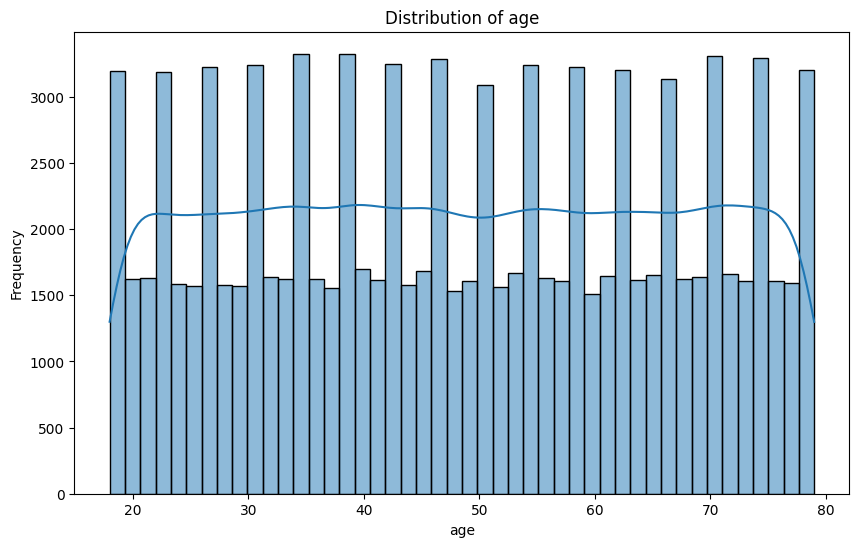

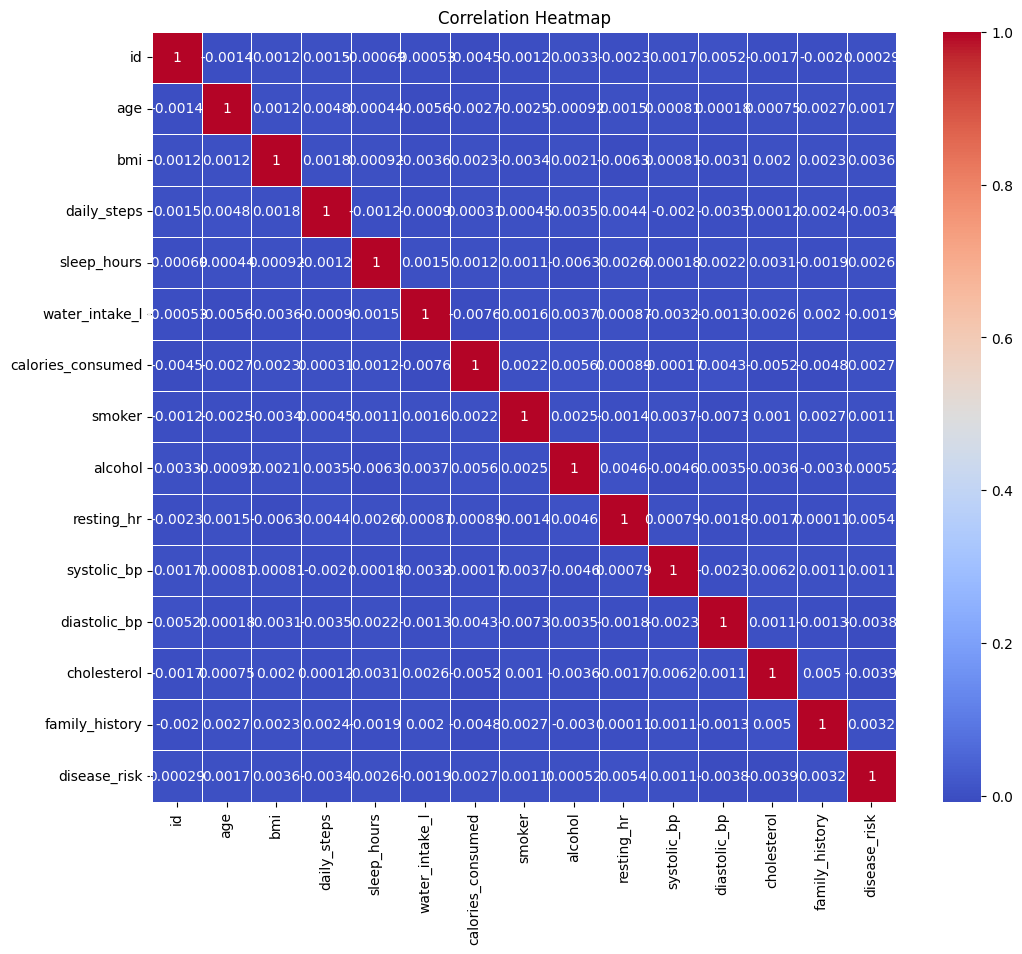

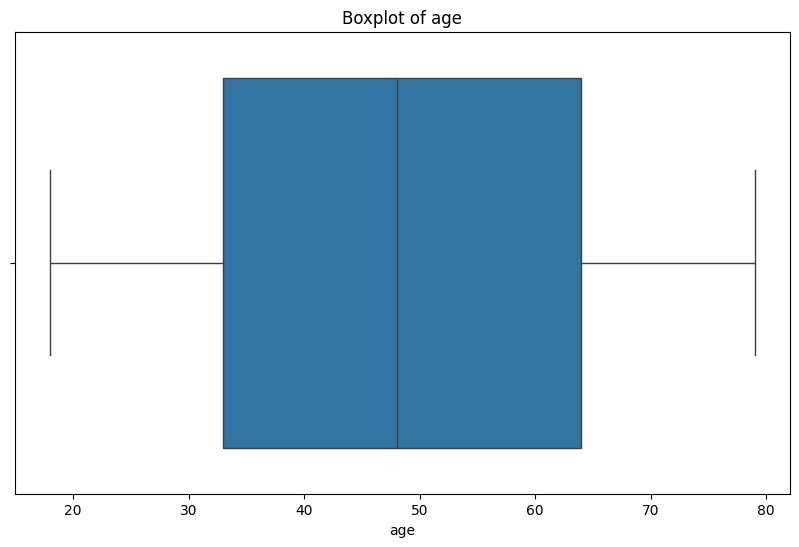

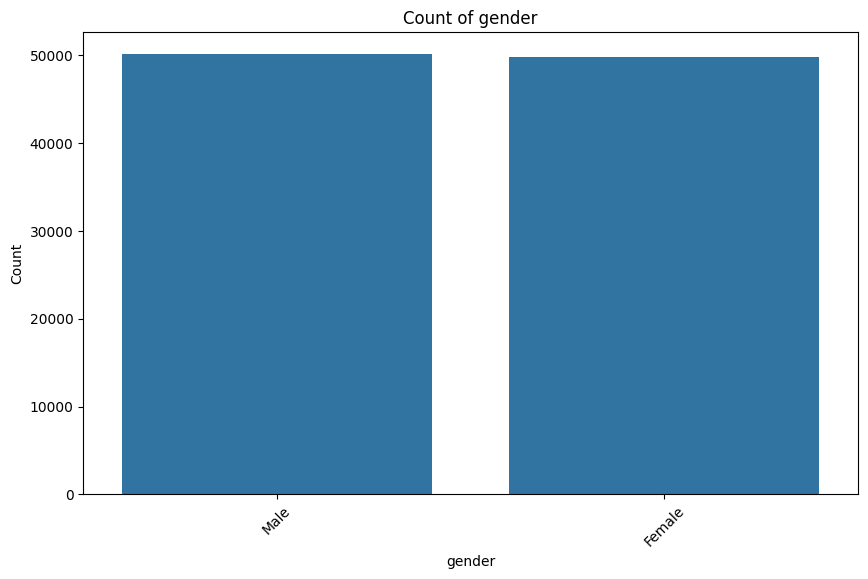

In [9]:
# call the functions to visualize the data
plot_distribution('age')
plot_correlation_heatmap(df)
plot_boxplot('age')
plot_categorical_count('gender')

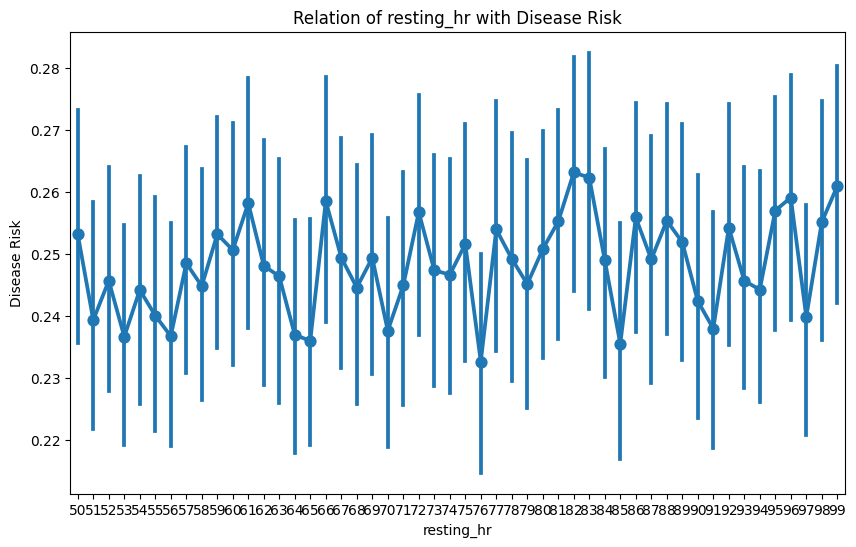

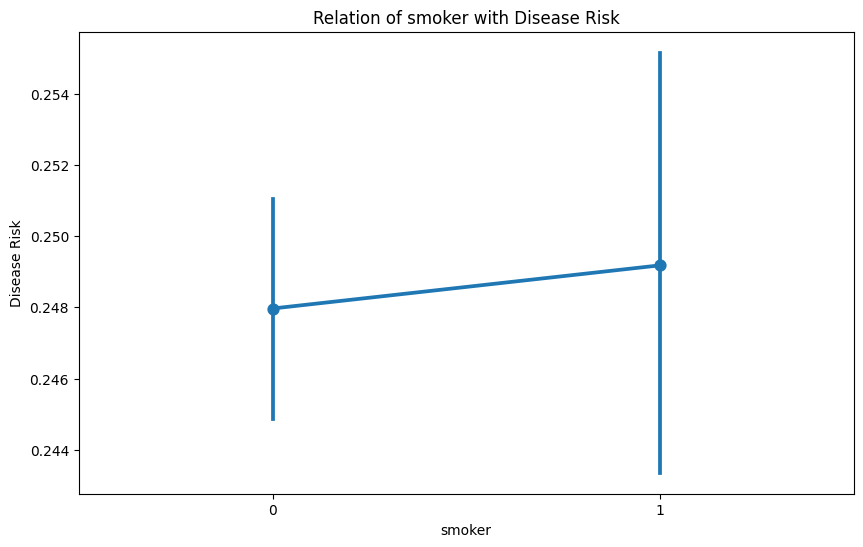

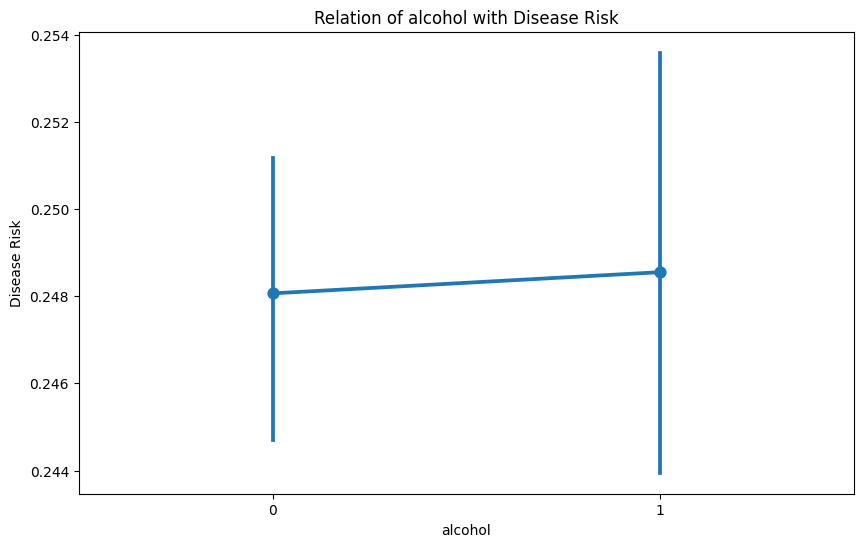

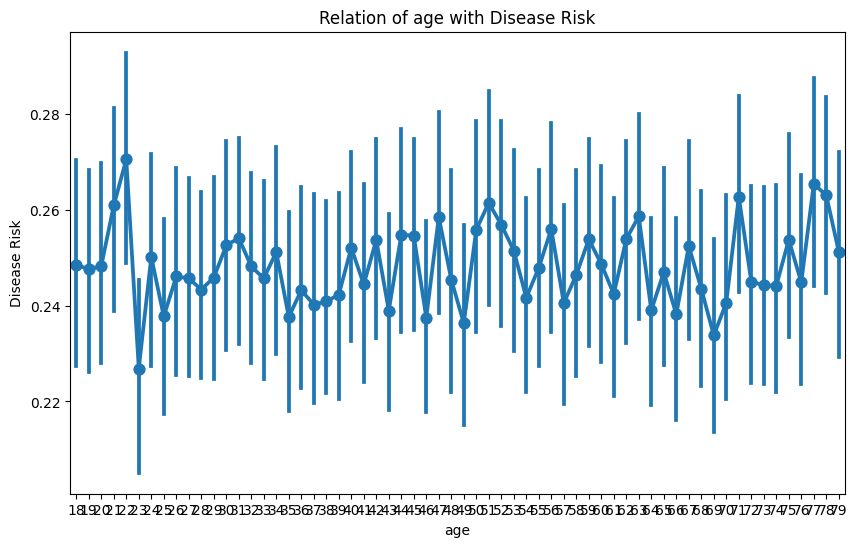

In [10]:
plot_disease_risk_relation('resting_hr')
plot_disease_risk_relation('smoker')
plot_disease_risk_relation('alcohol')
plot_disease_risk_relation('age')

In [11]:
initial_rows = len(df)
df = df.drop_duplicates()
print(f"Duplicates removed: {initial_rows - len(df)}")

# Check for missing values [cite: 31]
print("\nMissing Values Check:")
print(df.isnull().sum())

# ==========================================
# 2. Data Preparation Plan
# ==========================================

# 2.1 Feature Exclusion
# Drop 'ID' as it carries no predictive value [cite: 34]
if 'id' in df.columns:
    df = df.drop('id', axis=1)

Duplicates removed: 0

Missing Values Check:
id                   0
age                  0
gender               0
bmi                  0
daily_steps          0
sleep_hours          0
water_intake_l       0
calories_consumed    0
smoker               0
alcohol              0
resting_hr           0
systolic_bp          0
diastolic_bp         0
cholesterol          0
family_history       0
disease_risk         0
dtype: int64


In [12]:
df.describe()

,age,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history,disease_risk
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,48.525990,29.024790,10479.87029,6.491784,2.751496,2603.341200,0.200940,0.300020,74.457420,134.58063,89.508850,224.300630,0.299150,0.248210
std,17.886768,6.352666,5483.63236,2.021922,1.297338,807.288563,0.400705,0.458269,14.423715,25.95153,17.347041,43.327749,0.457888,0.431976
min,18.000000,18.000000,1000.00000,3.000000,0.500000,1200.000000,0.000000,0.000000,50.000000,90.00000,60.000000,150.000000,0.000000,0.000000
25%,33.000000,23.500000,5729.00000,4.700000,1.600000,1906.000000,0.000000,0.000000,62.000000,112.00000,74.000000,187.000000,0.000000,0.000000
50%,48.000000,29.000000,10468.00000,6.500000,2.800000,2603.000000,0.000000,0.000000,74.000000,135.00000,89.000000,224.000000,0.000000,0.000000
75%,64.000000,34.500000,15229.00000,8.200000,3.900000,3299.000000,0.000000,1.000000,87.000000,157.00000,105.000000,262.000000,1.000000,0.000000
max,79.000000,40.000000,19999.00000,10.000000,5.000000,3999.000000,1.000000,1.000000,99.000000,179.00000,119.000000,299.000000,1.000000,1.000000


In [13]:
target = 'disease_risk'

# Define Continuous Features for Scaling [cite: 57, 59]
continuous_features = [
    'age', 'bmi', 'daily_steps', 'sleep_hours', 'water_intake_l', 
    'calories_consumed', 'resting_hr', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'family_history', 'smoker', 'alcohol'
]

# Define Categorical Features for Encoding 
categorical_features = ['gender']

In [14]:
# set the target variable and features
X = df.drop(columns=[target])
y = df[target]

In [15]:
y.value_counts()

disease_risk
0    75179
1    24821
Name: count, dtype: int64

In [16]:
# print the shape of the features and target variable
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (100000, 14)
Target shape: (100000,)


In [17]:
# define the proprocessing column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features), # Scale numerical features [cite: 42]
        ('cat', OneHotEncoder(drop=None, handle_unknown='ignore'), categorical_features) # Encode gender [cite: 37]
    ],
    remainder='passthrough' # Keep binary columns (smoker, alcohol, etc.) [cite: 39]
)

# 4. Data Partitioning

# Split into Training (80%) and Testing (20%) sets [cite: 64, 65]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 80000
Testing set size: 20000


In [19]:
# Initialize SMOTE 
# We apply this only to the training data within the pipeline
smote = SMOTE(random_state=42)

# Define Models [cite: 25, 74, 83]
# Note: We removed class_weight='balanced' because SMOTE now handles the imbalance
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42), # RFC [cite: 83]
}

In [20]:
# training and testing evals for each model using cross-validation pipeline
results = {}
print("\nStarting Model Training with SMOTE...")

for name, model in models.items():
    # Construct the Imbalanced-Learn Pipeline
    # Order: Preprocess (Scale/Encode) -> SMOTE (Oversample) -> Model (Train)
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', model)
    ])
    
    # 1. K-Fold Cross-Validation on Training Set [cite: 69]
    # The pipeline ensures SMOTE is applied *inside* each fold, preventing leakage
    cv = StratifiedKFold(n_splits=5)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
    print(f"\n--- {name} ---")
    print(f"5-Fold CV F1-Score (Train): {np.mean(cv_scores):.4f}")
    
    # 2. Train on full training set
    # This applies SMOTE to the entire X_train before fitting
    pipeline.fit(X_train, y_train)
    
    # 3. Predict on Test Set [cite: 67]
    # SMOTE is NOT applied to X_test (pipeline handles this automatically)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # 4. Calculate Metrics [cite: 115, 118, 120]
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    results[name] = {
        "Accuracy": acc,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": auc
    }
    
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Recall: {rec:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test ROC AUC: {auc:.4f}")


Starting Model Training with SMOTE...

--- Logistic Regression ---
5-Fold CV F1-Score (Train): 0.3307
Test Accuracy: 0.4998
Test Recall: 0.5038
Test F1 Score: 0.3333
Test ROC AUC: 0.5031

--- Random Forest ---
5-Fold CV F1-Score (Train): 0.1253
Test Accuracy: 0.7106
Test Recall: 0.0657
Test F1 Score: 0.1012
Test ROC AUC: 0.4956


In [ ]:
# training the XGBoost model separately with SMOTE
print("\n--- XGBoost Classifier ---")
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])  

# trainn the model on the train and test dataset and evaluate the metrics
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print("----XGBoost Metrics----")
acc_xgb = accuracy_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb) 

In [ ]:
# Trainig the svc model separately with SMOTE
print("\n--- Support Vector Classifier ---")
svc_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', SVC(random_state=42, probability=True))
])

svc_pipeline.fit(X_train, y_train)
y_pred_svc = svc_pipeline.predict(X_test)
y_prob_svc = svc_pipeline.predict_proba(X_test)[:, 1]   

print("----SVC Metrics----")
acc_svc = accuracy_score(y_test, y_pred_svc)
rec_svc = recall_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)
auc_svc = roc_auc_score(y_test, y_prob_svc)

In [ ]:
# final model comparison
print("\nFinal Model Comparison:")
results_df = pd.DataFrame(results).T
results_df.loc['XGBoost'] = [acc_xgb, rec_xgb, f1_xgb, auc_xgb]
results_df.loc['SVC'] = [acc_svc, rec_svc, f1_svc, auc_svc]
print(results_df)

# Identify best model based on Recall (Sensitivity) as per clinical importance [cite: 121]
best_model = results_df['Recall'].idxmax()
print(f"\nBased on Recall (Sensitivity), the best model is: {best_model}")


Final Model Comparison:
                     Accuracy    Recall  F1 Score   ROC AUC
Logistic Regression   0.49980  0.503828  0.333333  0.503064
Random Forest         0.71055  0.065673  0.101227  0.495568

Based on Recall (Sensitivity), the best model is: Logistic Regression


In [22]:
# features importance for the best model
best_model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', models[best_model])
])

best_model_pipeline.fit(X_train, y_train)
if best_model == "Random Forest":
    importances = best_model_pipeline.named_steps['classifier'].feature_importances_
    feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print("\nFeature Importances for the Best Model:")
    print(feature_importance_df.head(10))
elif best_model == "XGBoost":
    importances = best_model_pipeline.named_steps['classifier'].feature_importances_
    feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print("\nFeature Importances for the Best Model:")
    print(feature_importance_df.head(10))
elif best_model == "Logistic Regression":
    coefficients = best_model_pipeline.named_steps['classifier'].coef_[0]
    feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    feature_importance_df['Importance'] = feature_importance_df['Coefficient'].abs()
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print("\nFeature Coefficients for the Best Model:")
    print(feature_importance_df.head(10))   
elif best_model == "SVM": 
    print("\nSVM does not provide feature importances directly. Consider using permutation importance or SHAP values for interpretation.")



Feature Coefficients for the Best Model:
              Feature  Coefficient  Importance
6          resting_hr     0.016159    0.016159
2         daily_steps    -0.012127    0.012127
14        gender_Male    -0.011921    0.011921
13      gender_Female     0.011742    0.011742
5   calories_consumed     0.011487    0.011487
8        diastolic_bp    -0.011020    0.011020
1                 bmi     0.007309    0.007309
10     family_history     0.007275    0.007275
0                 age     0.006646    0.006646
7         systolic_bp     0.005508    0.005508
